In [1]:
# Import libraries

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import pandas as pd
import numpy as np

import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

Using TensorFlow backend.


In [2]:
# Setup

EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 500
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 1000
MAX_NB_WORDS = 30000

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
df = pd.read_csv("dataset.csv")
df  = df.dropna(subset=['msg', 'role'])
df.describe()


weight_labels = df['role'].values.tolist()

In [4]:
# Same msg multiple users
df['role'] = df[['msg','role']].groupby(['msg'])['role'].transform(lambda x: ','.join(x))
df = df[['msg','role']].drop_duplicates()
print(df.describe())
df[:3]

                                                      msg      role
count                                               68235     68235
unique                                              68235      6282
top     dear louise markedup text quick start guide ju...  Employee
freq                                                    1      8700


msg  \
0  chinese wall training one hour scheduled dates...   
1                                              trip    
2  attached please find key contact list energy o...   

                                                role  
0  Manager,Vice President,Vice President,Vice Pre...  
1  President,President,President,President,Presid...  
2                        President,CEO,President,CEO

In [5]:
df['role']= df['role'].apply(lambda x: ','.join(list(set(x.split(',')))))
print(df[:3])

                                                 msg                    role
0  chinese wall training one hour scheduled dates...  Vice President,Manager
1                                              trip                President
2  attached please find key contact list energy o...           President,CEO


In [6]:
lines=df['msg'].values.tolist()
labels=df['role'].values.tolist()
review_lines = list()
for line in lines:
    review_lines.append(str(line).split())
review_lines[0]

# Make role list and convert to numbers
labelInt = {'CEO': 0,
 'Director': 1,
 'Employee': 2,
 'Manager': 3,
 'President': 4,
 'Trader': 5,
 'Vice President': 6}

labels = [x.split(',') for x in labels]
print(len(labels))
print(labels[:5])

for i,label in enumerate(labels):
    for j,x in enumerate(label):
        labels[i][j]=labelInt[x]
        
print(len(labels))
print(labels[:5])

68235
[['Vice President', 'Manager'], ['President'], ['President', 'CEO'], ['CEO'], ['Employee']]
68235
[[6, 3], [4], [4, 0], [0], [2]]


In [7]:
encode_labels = np.zeros((len(labels), 7))

for i,label in enumerate(labels):
    for x in label:
        encode_labels[i][x]=1
        
encode_labels[:5]

array([[0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

In [8]:
import os
embeddings_index={}
f=open(os.path.join('','glove.twitter.27B.100d.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close

<function TextIOWrapper.close()>

In [9]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences=tokenizer_obj.texts_to_sequences(review_lines)

word_index=tokenizer_obj.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(len(data))
print(data[1])

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', encode_labels.shape)

68235
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0


## Try with ANN

In [10]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='sigmoid',input_shape=(MAX_SEQUENCE_LENGTH,)))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.1)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(), #CategoricalCrossentropy
              metrics=METRICS)
model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 551,807
Trainable params: 551,807
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
history = model.fit(data, encode_labels, epochs=20, validation_split=0.4, verbose=1)

Train on 40941 samples, validate on 27294 samples
Epoch 1/20
40941/40941 [==============================] - 10s 240us/sample - loss: 7182051.3715 - tp: 13879.0000 - fp: 26724.0000 - tn: 207839.0000 - fn: 38145.0000 - accuracy: 0.7736 - precision: 0.3418 - recall: 0.2668 - auc: 0.5776 - val_loss: 20160528.0438 - val_tp: 10310.0000 - val_fp: 16984.0000 - val_tn: 141570.0000 - val_fn: 22194.0000 - val_accuracy: 0.7949 - val_precision: 0.3777 - val_recall: 0.3172 - val_auc: 0.6050
Epoch 2/20
40941/40941 [==============================] - 8s 196us/sample - loss: 54990266.5770 - tp: 13979.0000 - fp: 26961.0000 - tn: 207602.0000 - fn: 38045.0000 - accuracy: 0.7732 - precision: 0.3415 - recall: 0.2687 - auc: 0.5769 - val_loss: 135561190.4869 - val_tp: 8319.0000 - val_fp: 18975.0000 - val_tn: 139579.0000 - val_fn: 24185.0000 - val_accuracy: 0.7741 - val_precision: 0.3048 - val_recall: 0.2559 - val_auc: 0.5681
Epoch 3/20
40941/40941 [==============================] - 8s 195us/sample - loss: 1390

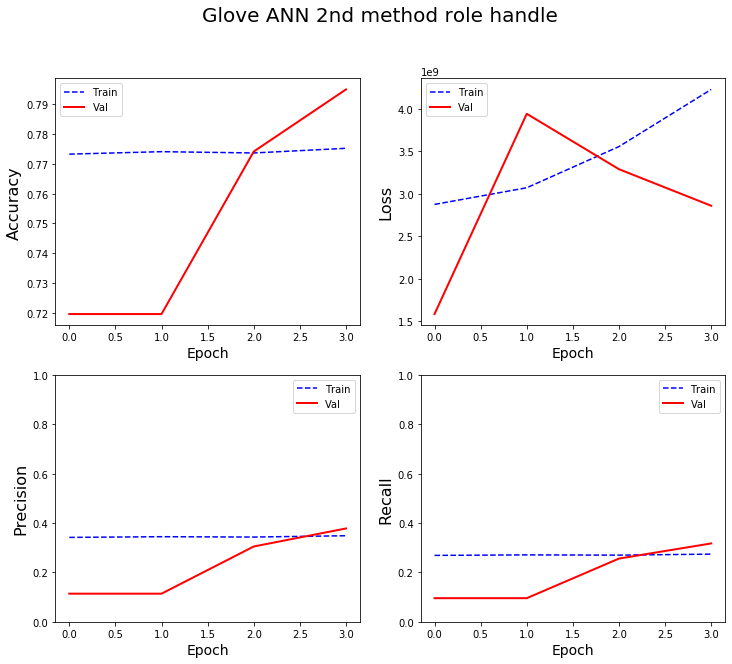

In [73]:
figName = "Glove ANN 2nd method role handle"

metrics =  ['accuracy', 'loss', 'precision', 'recall']
fig = plt.figure()
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')

## Try ANN with weight

In [78]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(weight_labels),weight_labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.6316886780753967,
 1: 1.5797845860376394,
 2: 0.4274146243218408,
 3: 1.3423906382810493,
 4: 2.2752010184937013,
 5: 2.140845869639232,
 6: 0.5010513858372057}

In [79]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='sigmoid',input_shape=(MAX_SEQUENCE_LENGTH,)))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.1)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [80]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(), #CategoricalCrossentropy
              metrics=METRICS)
model.summary();

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_13 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_14 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 707       
Total params: 551,807
Trainable params: 551,807
Non-trainable params: 0
_________________________________________________________________
